# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


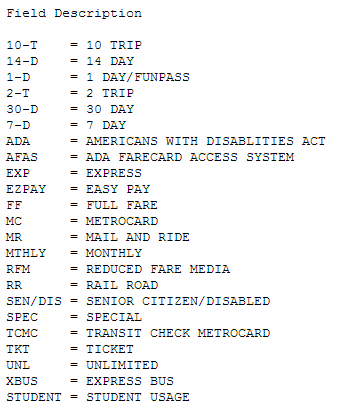

In [2]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn import preprocessing

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station600, per ticket type23) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [3]:
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")

In [4]:
mta = np.load('%s/MTA_Fare.npy'%os.getenv('PUIDATA'))

In [5]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)
#600 station, 23 card type, 194 week data

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [7]:
#194 weeks index
dateindex = pd.date_range(start='05/19/2010',end='02/19/2014',freq='7D')[:-3]
dateindex

DatetimeIndex(['2010-05-19', '2010-05-26', '2010-06-02', '2010-06-09',
               '2010-06-16', '2010-06-23', '2010-06-30', '2010-07-07',
               '2010-07-14', '2010-07-21',
               ...
               '2013-11-27', '2013-12-04', '2013-12-11', '2013-12-18',
               '2013-12-25', '2014-01-01', '2014-01-08', '2014-01-15',
               '2014-01-22', '2014-01-29'],
              dtype='datetime64[ns]', length=194, freq='7D')

In [8]:
mtaflat = mta.flatten().astype(float)
for i in range(len(mtaflat)):
    if mtaflat[i] == -1:
        mtaflat[i] = nan
mta = mtaflat.reshape((600,23,194))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'Time series on each station each ride type weekly swipe since 2012-05-19 to 2014-02-19(log10)')

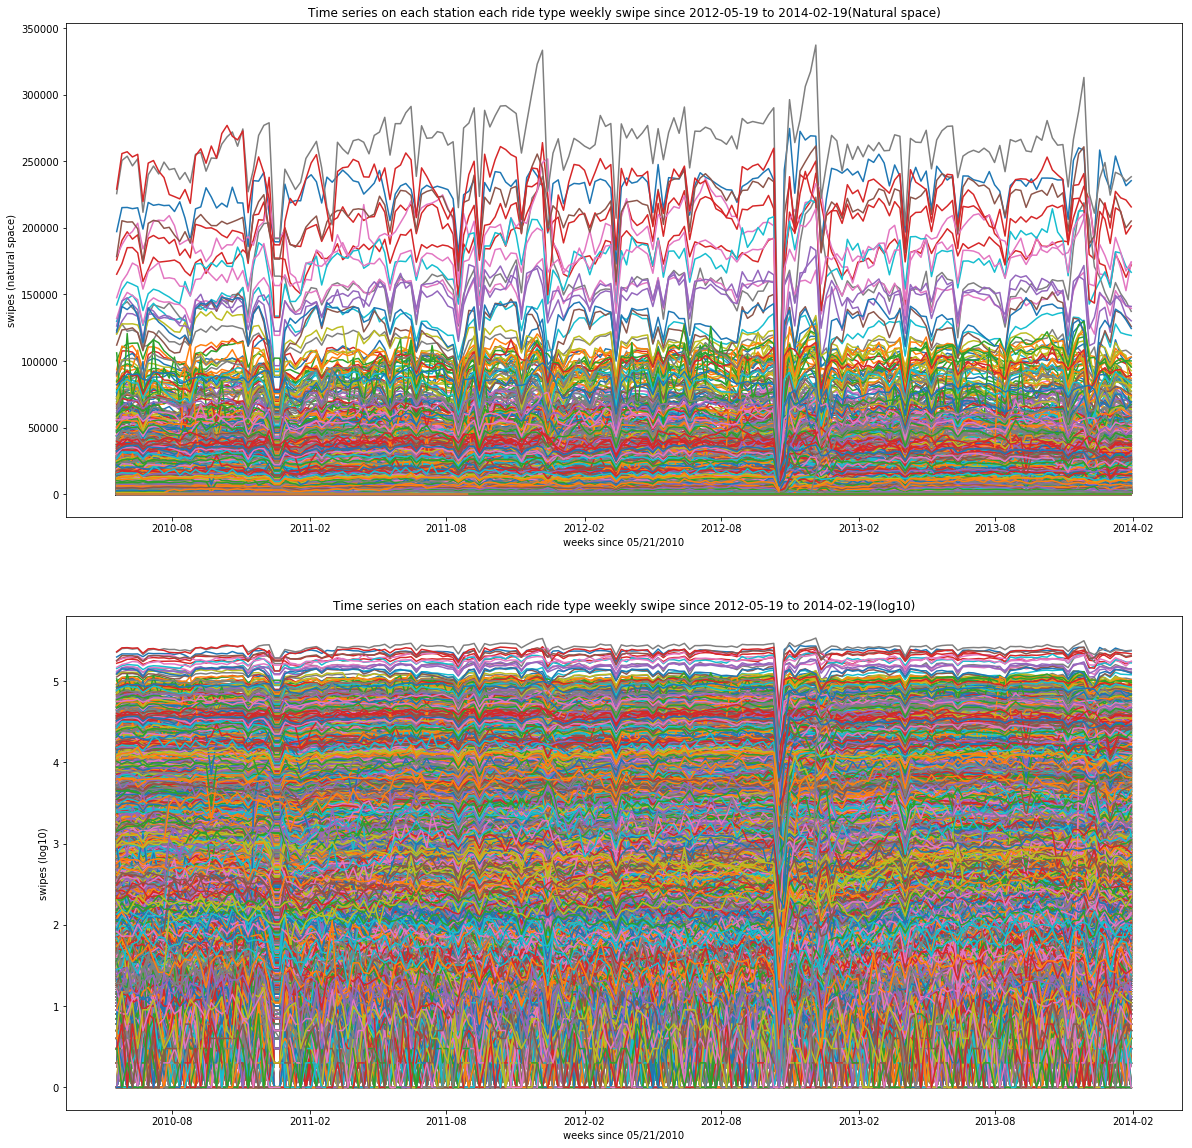

In [9]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
for i in range(mta.shape[0]): #600 station
    for j in range(mta.shape[1]): #23 cards
        ax1.plot(dateindex,mta[i,j, :])
        ax2.plot(dateindex,np.log10(mta[i,j, :]))

ax1.set_xlabel("weeks since 05/21/2010")
ax1.set_ylabel("swipes (natural space)")
ax1.set_title('Time series on each station each ride type weekly swipe since 2012-05-19 to 2014-02-19(Natural space)' )
ax2.set_xlabel("weeks since 05/21/2010")
ax2.set_ylabel("swipes (log10)")
ax2.set_title('Time series on each station each ride type weekly swipe since 2012-05-19 to 2014-02-19(log10)')

#### Figure 2: time series for all ride types and all stations in log space.( The first graph is natural space, the second is in log10 scale)

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [10]:
# After observation, there is one point is significantly lower than mean-3sigma. 
#Almost All the time series show this phenomenon. So here I checked the one series the lower threshold.
mtamean = np.nanmean(np.nansum(np.nansum(mta,axis=0),axis=0))
week = np.nansum(np.nansum(mta,axis=0),axis=0)
mtastd = week.std()
lowerlim = mtamean - 3*mtastd

In [11]:
mtamean

29781349.87113402

In [12]:
for j in range(len(week)):
    if week[j] < lowerlim:
        print(dateindex[j])

2012-10-17 00:00:00


It shows during  the week around 2012/10/17 event happened. It shows hurricane Sandy. US President Barack Obama has declared a "major disaster" in New York state after storm Sandy smashed into the US East Coast, causing flooding and cutting power to millions. A record 4m (13ft) tidal surge sent seawater cascading into large parts of New York City's subway system.[https://en.wikipedia.org/wiki/Hurricane_Sandy]

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [13]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

In [14]:
rt_mta = np.nanmean(mta,axis=0)
rt_mta.shape
#collapse the 600 station and make average

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(23, 194)

In [15]:
dt_mta = pd.DataFrame(rt_mta.T,columns=ridetype)
dt_mta.head()

10t          14d          1d          2t         30d           7d  \
0  24880.119048  1148.320346  103.465368  403.790043  101.316017  8003.123377   
1  27173.229935  1265.798265  111.683297  432.167028  139.594360  8637.327549   
2  27573.708423  1266.077754  111.524838  431.248380  123.097192  8710.647948   
3  27329.751620  1215.123110  112.447084  424.166307   80.840173  8710.049676   
4  27607.099138  1182.883621  110.243534  420.006466   75.883621  8460.012931   

            ada       afas         exp           ez  ...        month  \
0  18510.686147  21.781385  721.205628  1108.294372  ...   266.523810   
1  20577.861171  25.698482  613.351410  1253.845987  ...   329.605206   
2  20467.684665  26.516199  652.328294  1329.453564  ...   327.295896   
3  20410.542117  24.235421  659.855292  1309.438445  ...   317.697624   
4  20030.176724  22.661638  723.663793  1214.323276  ...   297.172414   

           rfm          rr        sen     spec        tcmc          t  \
0  1710.194805  129.456710  61.084416  0.00000  269.898268  45.584416   
1  1969.778742  150.127983  70.136659  0.00000  264.019523  47.006508   
2  1974.349892  150.267819  70.449244  0.00000  263.889849  46.291577   
3  1949.349892  147.082073  69.987041  0.00000  263.609071  46.717063   
4  1843.907328  143.053879  68.821121  0.37931  258.137931  43.743534   

       umlim      xbus  stud  
0  13.264069  0.774892   NaN  
1  13.275488  1.028200   NaN  
2  14.017279  1.004320   NaN  
3  14.233261  1.045356   NaN  
4  13.605603  0.974138   NaN  

[5 rows x 23 columns]

In [16]:
#rolling mean 10
for i in ridetype:
    dt_mta[i+'ma'] = dt_mta[i].rolling(window=10,center=True).mean()
dt_mta.tail(10)

10t          14d          1d          2t         30d  \
184  31679.019523  1695.290672  135.917570  419.236443  122.930586   
185  24556.158009  1290.781385  110.000000  356.292208   48.967532   
186  24240.669546  1120.855292   97.522678  321.062635   54.645788   
187  27846.028139  1438.378788  121.491342  385.032468  146.564935   
188  27872.161987  1609.049676  130.516199  418.028078  140.101512   
189  25828.939394  1327.476190  111.826840  365.653680   93.995671   
190  28440.173160  1544.841991  123.826840  410.311688  103.471861   
191  28548.939394  1504.619048  127.209957  398.785714  132.253247   
192  26999.473002  1447.576674  122.084233  388.831533  128.293737   
193  26969.582251  1470.772727  119.463203  388.231602  101.426407   

               7d           ada      afas       exp        ez     ...       \
184  13858.000000  18399.845987  0.008677  0.008677  0.000000     ...        
185  11321.569264  12606.588745  0.002165  0.006494  0.002165     ...        
186  11518.196544  12725.095032  0.002160  0.012959  0.004320     ...        
187  11386.151515  17888.714286  0.006494  0.008658  0.000000     ...        
188  11721.758099  19090.276458  0.010799  0.004320  0.002160     ...        
189  10757.720779  17857.915584  0.004329  0.004329  0.000000     ...        
190  11929.898268  20447.268398  0.004329  0.012987  0.002165     ...        
191  12119.560606  20149.911255  0.004329  0.000000  0.006494     ...        
192  11989.831533  19504.524838  0.006479  0.010799  0.000000     ...        
193  11699.300866  18842.316017  0.000000  0.006494  0.002165     ...        

        monthma        rfmma        rrma       senma     specma      tcmcma  \
184  176.766460  1169.371726  361.559219  194.723811  76.293466  445.985200   
185  172.866744  1160.560331  356.581755  191.910624  74.566643  432.232277   
186  172.996711  1163.530112  357.965103  192.047347  73.883796  420.945163   
187  179.062079  1198.145913  369.518350  198.035442  73.180549  414.186289   
188  176.575686  1199.021722  368.270618  198.289654  71.003227  406.194928   
189  171.923428  1186.308498  361.968382  196.458495  68.936149  400.677851   
190         NaN          NaN         NaN         NaN        NaN         NaN   
191         NaN          NaN         NaN         NaN        NaN         NaN   
192         NaN          NaN         NaN         NaN        NaN         NaN   
193         NaN          NaN         NaN         NaN        NaN         NaN   

           tma    umlimma    xbusma       studma  
184  50.114368  12.443734  2.083501  2692.207048  
185  47.244917  11.801913  1.897061  2657.325873  
186  46.255824  11.546146  1.831979  2544.112498  
187  46.551928  11.547229  1.837390  2566.624835  
188  46.545881  11.516343  1.775619  2529.610796  
189  46.704915  11.598837  1.712807  2311.997455  
190        NaN        NaN       NaN          NaN  
191        NaN        NaN       NaN          NaN  
192        NaN        NaN       NaN          NaN  
193        NaN        NaN       NaN          NaN  

[10 rows x 46 columns]

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


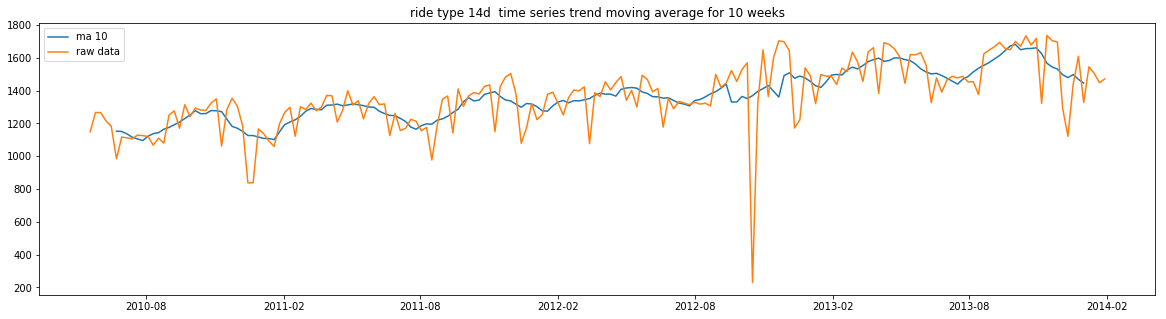

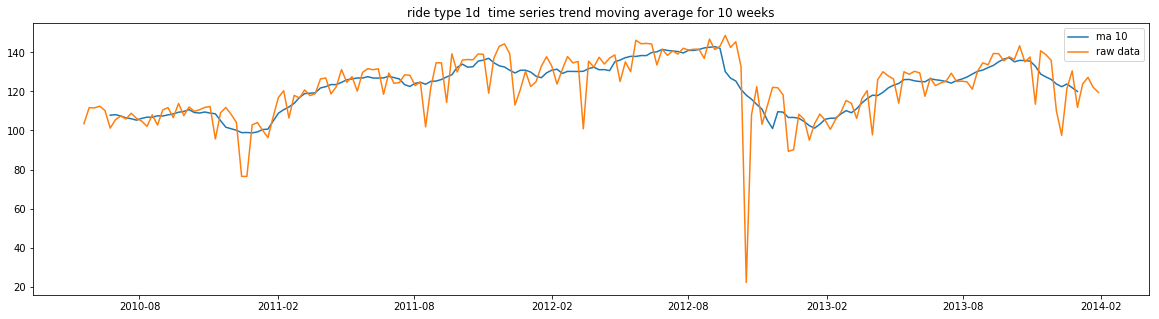

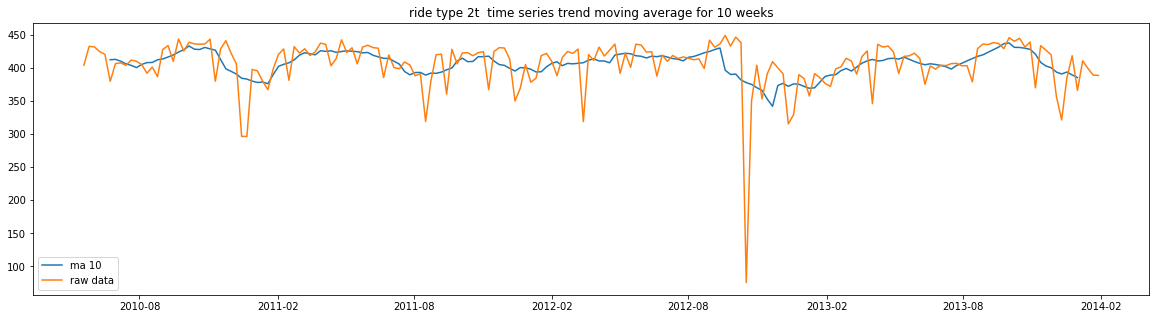

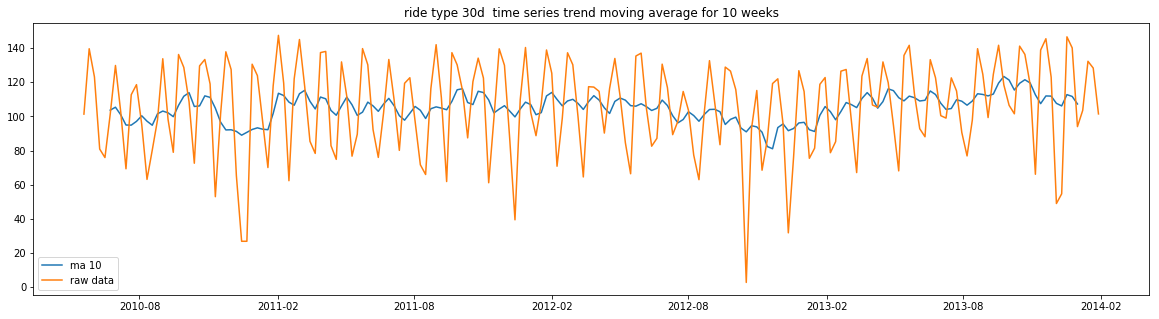

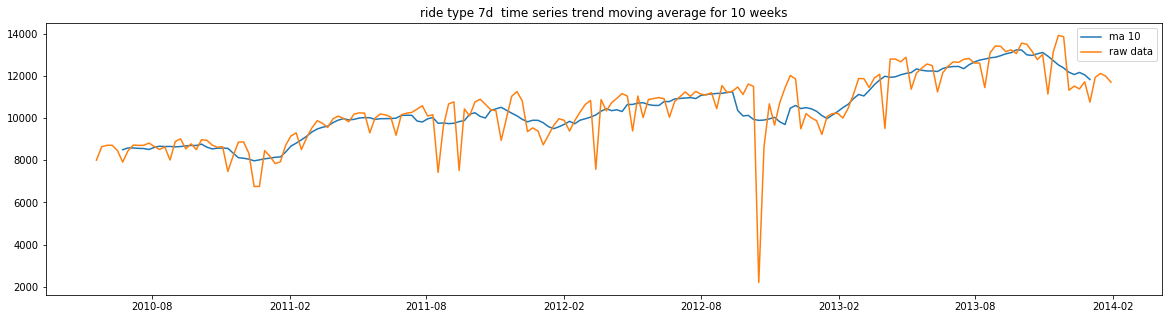

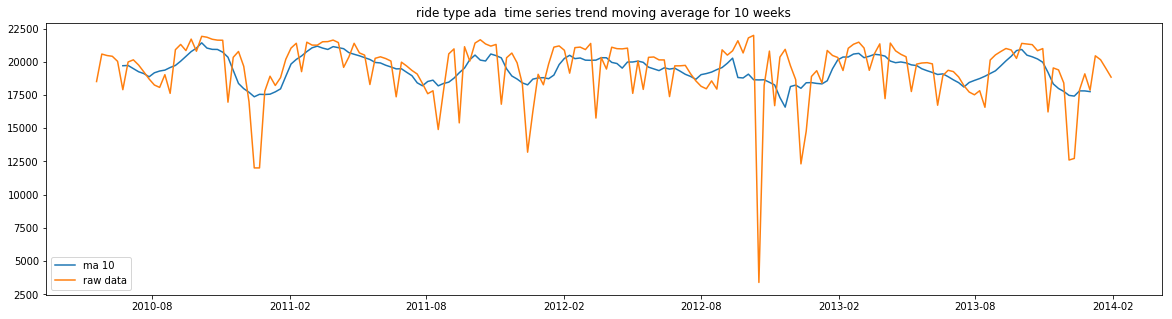

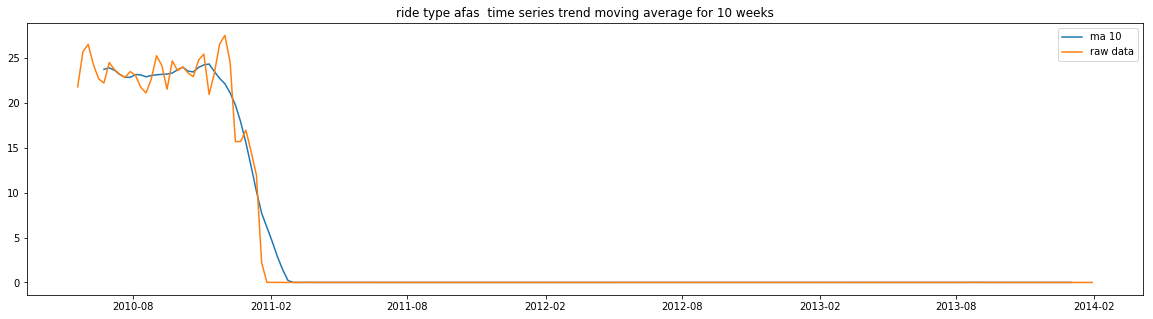

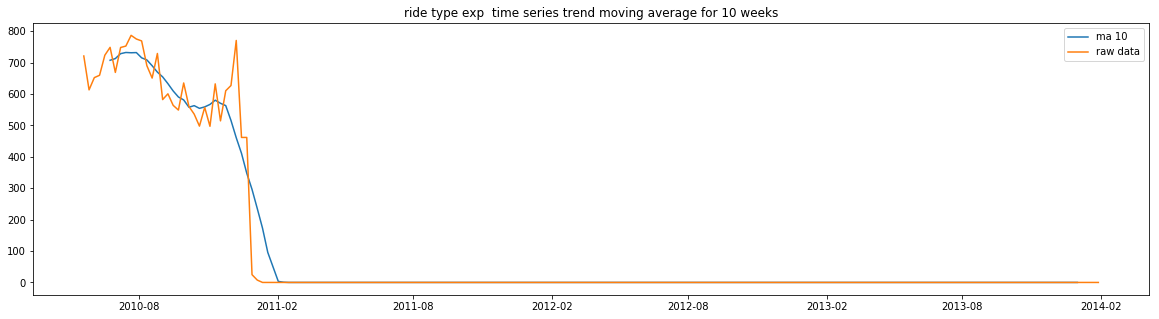

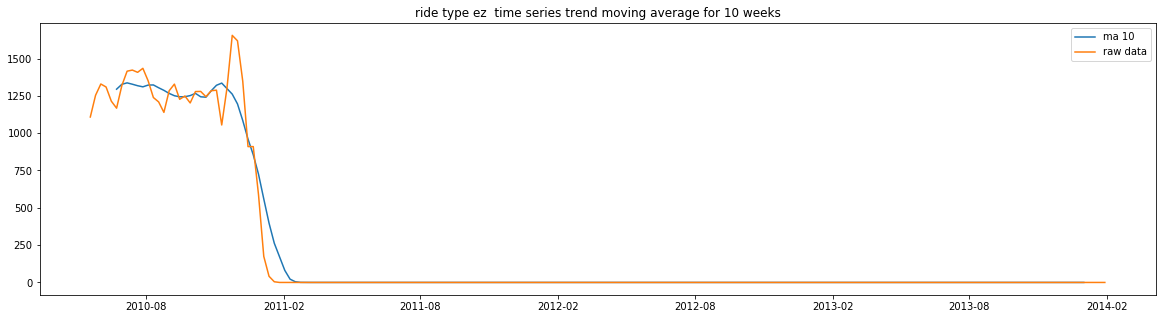

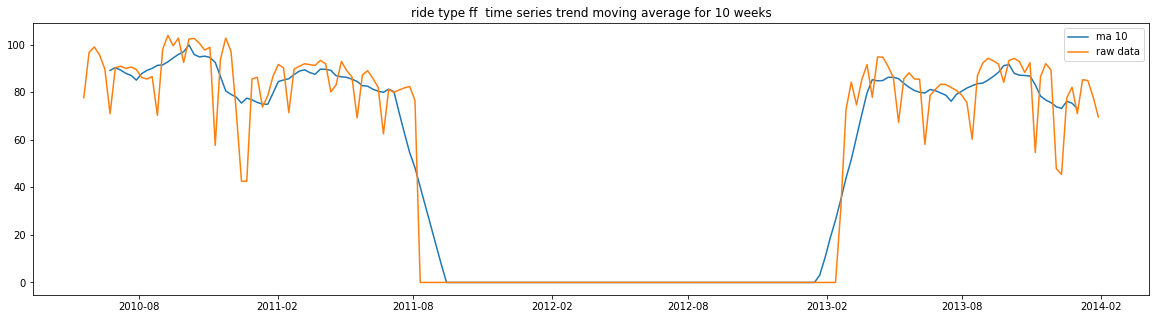

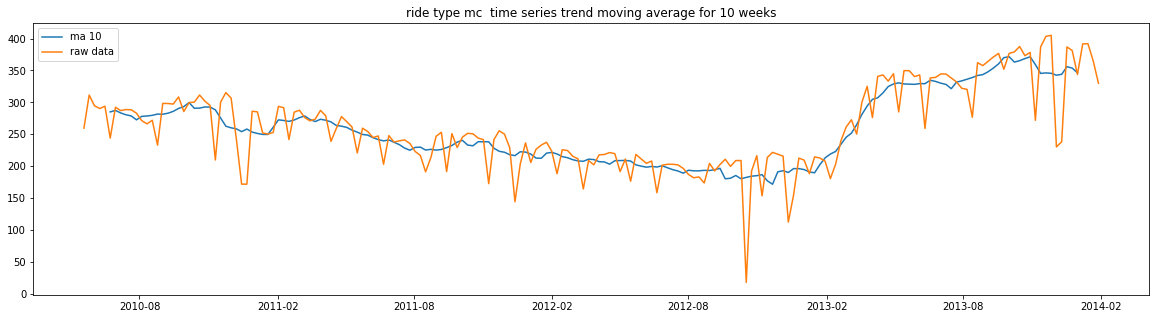

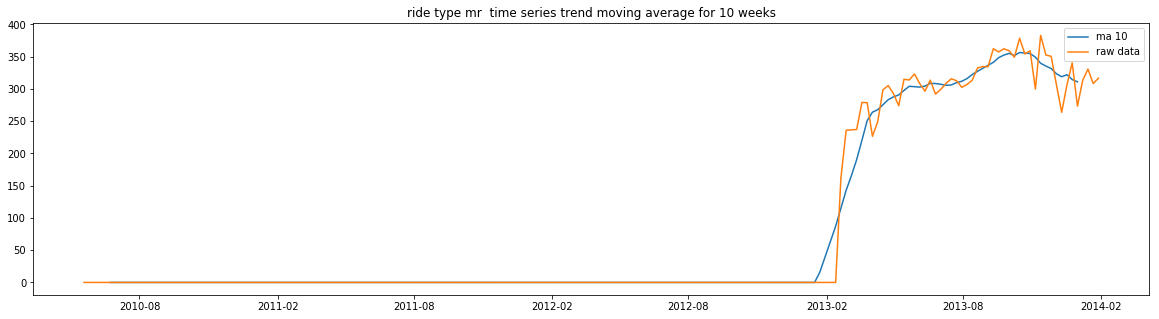

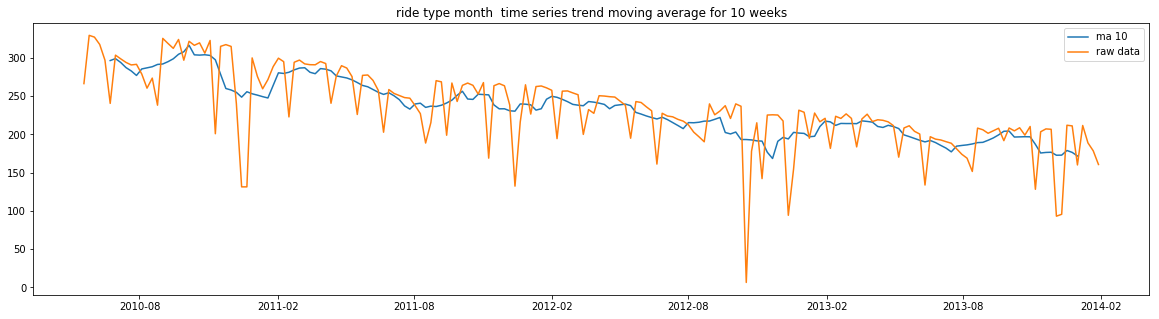

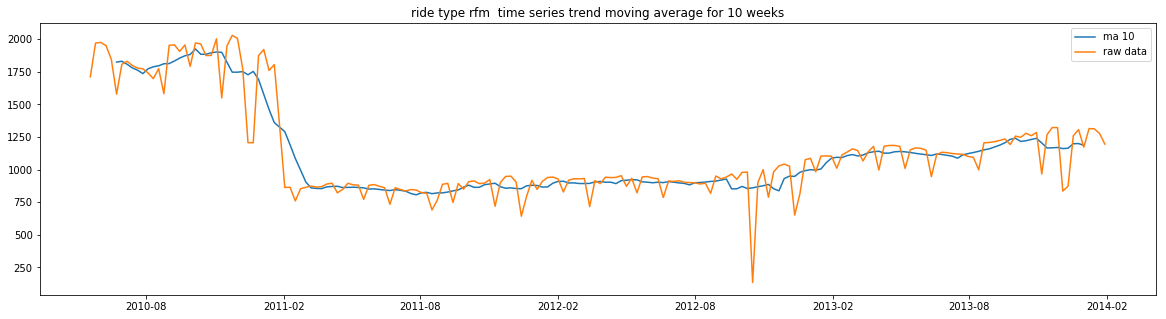

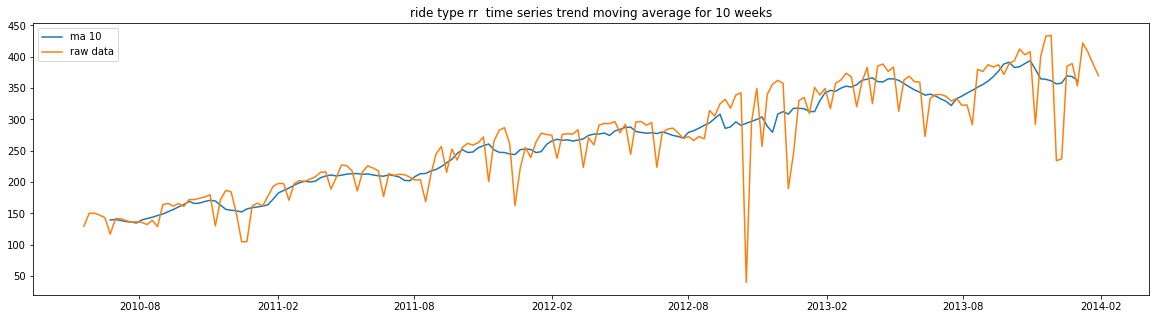

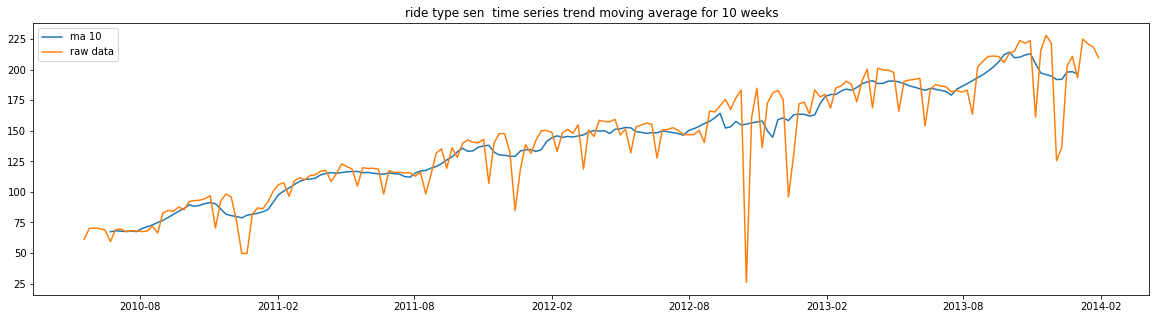

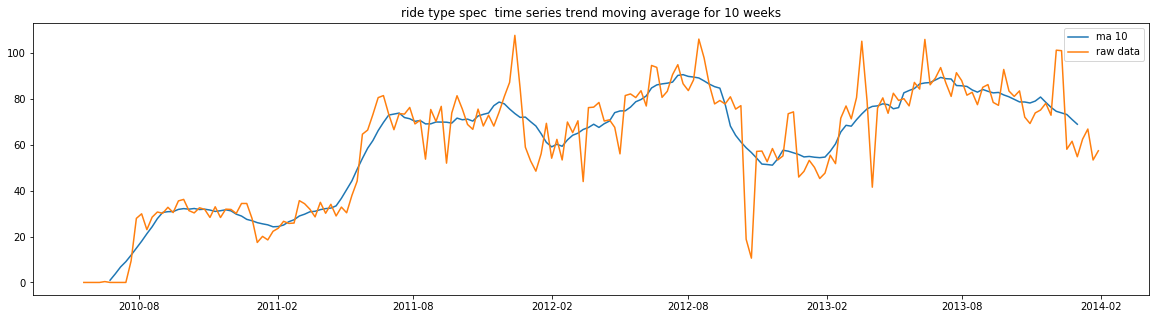

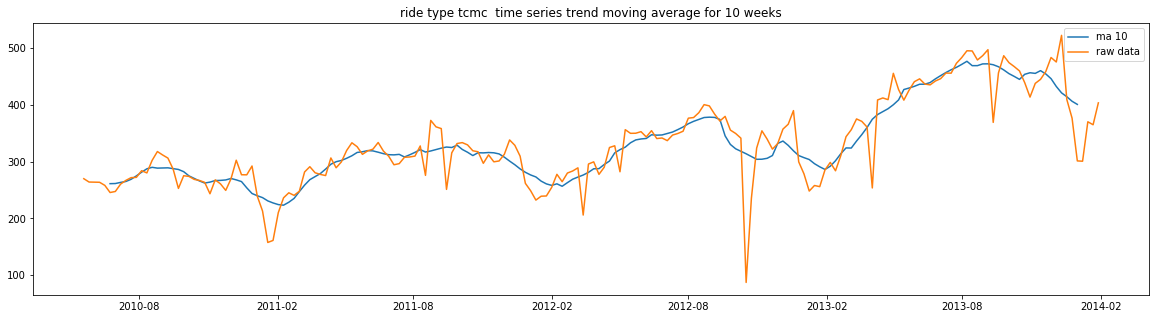

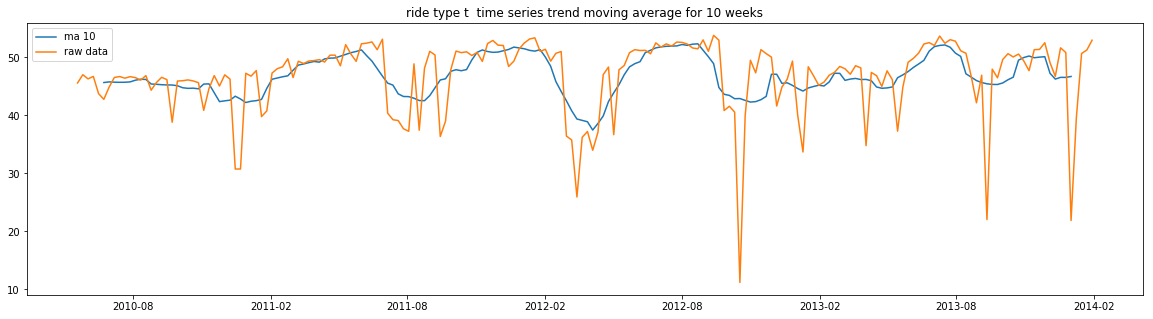

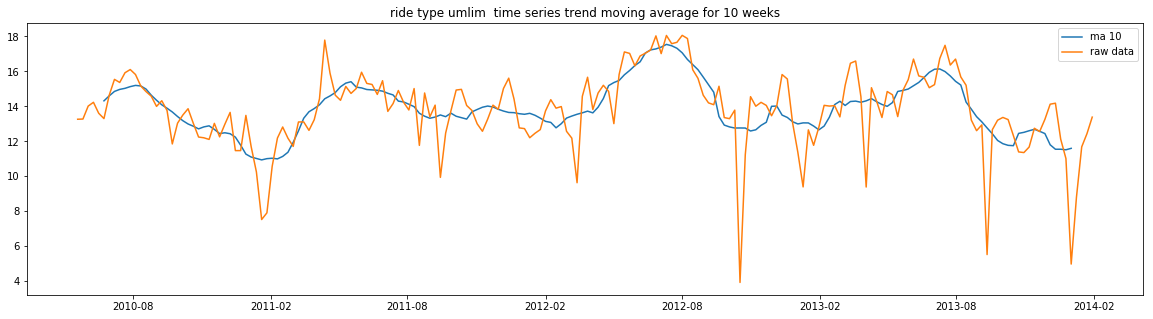

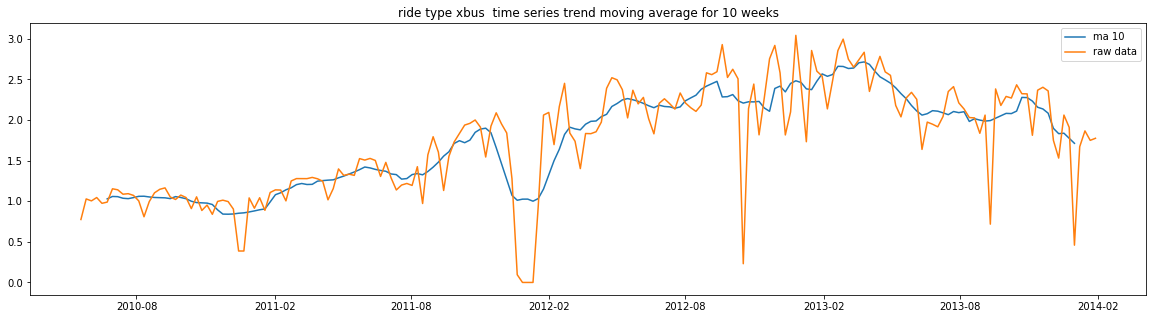

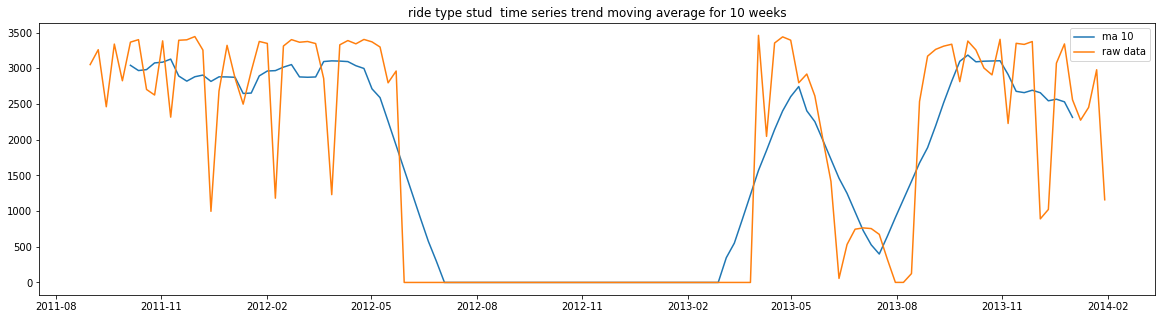

In [17]:
rate_type = {}
std_type = {}
for i in range(24,len(dt_mta.columns)):
    plt.figure(figsize=(20,5))
    plt.plot(dateindex, dt_mta.iloc[:,i], label = 'ma 10')
    pl.plot(dateindex, dt_mta.iloc[:,i-23], label='raw data')
    plt.title('ride type %s  time series trend moving average for 10 weeks'%dt_mta.columns[i-23])
    rate_type[dt_mta.columns[i]] = dt_mta.iloc[5,i]/dt_mta.iloc[188,i]
    std_type[dt_mta.columns[i]] =  np.nanstd(dt_mta.iloc[:,i])
    plt.legend()


The list of 23 figure are the smooth moving/rolling average for 10 weeks on 23 individual ride type.

In [18]:
print(rate_type)
print('the max ratio ride type is %s'%max(rate_type,key=rate_type.get))
print('the min ratio ride type is %s'%min(rate_type,key=rate_type.get))

print(std_type)

{'14dma': 0.7849818714780032, '1dma': 0.8843335407812187, '2tma': 1.058964423720749, '30dma': 0.9280839529550693, '7dma': 0.7053173119558039, 'adama': 1.1064513148118582, 'afasma': 4570.597359107216, 'expma': 90904.31464195842, 'ezma': 599078.3787456211, 'ffma': 1.1832883628383302, 'mcma': 0.805807895220259, 'mrma': 3.9810845958431466e-05, 'monthma': 1.6801362319201458, 'rfmma': 1.5210583996064977, 'rrma': 0.37854044983996143, 'senma': 0.34007784338498337, 'specma': 0.013808951270130345, 'tcmcma': 0.6429361378584463, 'tma': 0.9809802102996099, 'umlimma': 1.2432348888407376, 'xbusma': 0.5794643527818849, 'studma': nan}
the max ratio ride type is ezma
the min ratio ride type is mrma
{'14dma': 143.99138795633363, '1dma': 12.081268061532873, '2tma': 16.875000701166094, '30dma': 7.485366057712851, '7dma': 1371.3503946290705, 'adama': 987.7728555629834, 'afasma': 8.182860232992779, 'expma': 218.82893132951403, 'ezma': 445.04901375782913, 'ffma': 40.613780543090535, 'mcma': 54.19737345115011,

The ratio shows ez-easy pay methof has overall decrease, while the mr-mail and ride. The second list shows the standard deviation to the type.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [19]:
#Clean the data from missing values (drop time series with NaNs)
#station and the 194 date becomes feature, so I broke them and made the slide for each records 
#and make a new label to represent the card type.

df = pd.DataFrame(mta[0,:,:])
df['type label'] = df.index
df['station label'] = 0
for i in range(1,600):
    df1 = pd.DataFrame(mta[i,:,:])
    df1['type label'] = df1.index #add 23 ride type as label
    df1['station label'] = i #add 600 station label
    frame = [df,df1]
    df = pd.concat(frame)

In [20]:
df.head()

0        1        2        3        4        5        6        7  \
0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0  71186.0  71498.0   
1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   2072.0   1999.0   
2    203.0    276.0    245.0    280.0    265.0    241.0    278.0    236.0   
3    883.0    958.0    976.0    987.0   1012.0    927.0    898.0    902.0   
4    358.0    529.0    422.0    261.0    248.0    362.0    479.0    345.0   

         8        9      ...            186      187      188      189  \
0  73801.0  72517.0      ...        46955.0  39050.0  37384.0  33864.0   
1   2031.0   1980.0      ...          965.0   1284.0   1407.0   1085.0   
2    258.0    264.0      ...          150.0    194.0    183.0    185.0   
3    907.0    907.0      ...          388.0    517.0    593.0    498.0   
4    192.0    414.0      ...          124.0    349.0    357.0    197.0   

       190      191      192      193  type label  station label  
0  38358.0  36527.0  33929.0  36824.0           0              0  
1   1389.0   1264.0   1172.0   1238.0           1              0  
2    200.0    186.0    167.0    167.0           2              0  
3    538.0    545.0    516.0    489.0           3              0  
4    220.0    281.0    309.0    245.0           4              0  

[5 rows x 196 columns]

In [21]:
cleandf = df.dropna() #two more columns-- label for ride types, station label for 600 stations
cleandf.shape

(9174, 196)

In [22]:
cleandf.head()

0       1       2       3       4       5       6       7       8  \
0  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0  2888.0   
1   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0    97.0   
2     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0     3.0   
3    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0    43.0   
4     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   

        9      ...           186     187     188     189     190     191  \
0  3591.0      ...        2679.0  3337.0  3599.0  3273.0  3418.0  3746.0   
1    95.0      ...         160.0   180.0   204.0   166.0   191.0   212.0   
2     4.0      ...          18.0    20.0    19.0    13.0    19.0    26.0   
3    57.0      ...          24.0    20.0    25.0    29.0    31.0    28.0   
4     2.0      ...           1.0    10.0     8.0     6.0     5.0     5.0   

      192     193  type label  station label  
0  3406.0  3217.0           0              2  
1   209.0   211.0           1              2  
2    20.0    22.0           2              2  
3    24.0    22.0           3              2  
4     6.0     0.0           4              2  

[5 rows x 196 columns]

In [23]:
#each week each station each type swipe mean(use unclean dataframe df)
stationsmeans = pd.DataFrame(df.groupby('station label').mean().iloc[:, :-2].mean(axis = 1))
stationsmeans.shape

(600, 1)

In [24]:
#each week each station each type swipe( use unclean dataframe df)
stationsstd = pd.DataFrame(df.groupby('station label').mean().iloc[:, :-2].std(axis = 1))
stationsstd.shape

(600, 1)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [25]:
#Nan-clean: I have already dropna in previous code and make concatenate, but this is another solution
#stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
#stationid[mta.reshape(600*23, 194).std(1) > 0]
stationsmeans = pd.DataFrame(cleandf.groupby('station label').mean().iloc[:, :-2].mean(axis = 1),columns=['station_mean'])
stationsstd = pd.DataFrame(cleandf.groupby('station label').mean().iloc[:, :-2].std(axis = 1),columns=['station_std'])
#clean station mean and std

In [26]:
stationsmeans.head()#clean nan dataset -station  mean

station_mean
station label              
2                314.981630
3                793.708196
4                893.143429
5                980.209845
6                608.295101

In [27]:
cleandf = cleandf.merge(stationsmeans,left_on='station label', right_on=stationsmeans.index)
cleandf = cleandf.merge(stationsstd,left_on='station label', right_on=stationsstd.index)

In [28]:
cleandf.shape

(9174, 198)

In [29]:
cleandf['normed_time_series_mean'] = cleandf.iloc[:,:-4].mean(axis=1)/cleandf.station_mean
cleandf['normed_time_series_std'] = cleandf.iloc[:,:-5].std(axis=1)/cleandf.station_std

In [30]:
cleandf.head()

0       1       2       3       4       5       6       7       8  \
0  3292.0  3429.0  3629.0  2808.0  3614.0  2601.0  2848.0  2798.0  2888.0   
1   110.0    92.0   102.0    79.0    93.0    74.0    72.0    92.0    97.0   
2     7.0     6.0    13.0     7.0     5.0     7.0     7.0     6.0     3.0   
3    41.0    51.0    47.0    37.0    50.0    43.0    44.0    32.0    43.0   
4     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0     0.0   

        9           ...               190     191     192     193  type label  \
0  3591.0           ...            3418.0  3746.0  3406.0  3217.0           0   
1    95.0           ...             191.0   212.0   209.0   211.0           1   
2     4.0           ...              19.0    26.0    20.0    22.0           2   
3    57.0           ...              31.0    28.0    24.0    22.0           3   
4     2.0           ...               5.0     5.0     6.0     0.0           4   

   station label  station_mean  station_std  normed_time_series_mean  \
0              2     314.98163     35.75284                11.267062   
1              2     314.98163     35.75284                 0.459035   
2              2     314.98163     35.75284                 0.056950   
3              2     314.98163     35.75284                 0.096062   
4              2     314.98163     35.75284                 0.009197   

   normed_time_series_std  
0               10.975718  
1                1.222660  
2                0.228182  
3                0.275089  
4                0.118767  

[5 rows x 200 columns]

In [31]:
#standardized 

t = cleandf.iloc[:,:-6].T
scaler = preprocessing.StandardScaler().fit(t)
data1_3s = scaler.transform(t)
standardized = pd.DataFrame(data1_3s).T
standardized.shape

(9174, 194)

Text(0,0.5,'standardized swipes for first 10 time series')

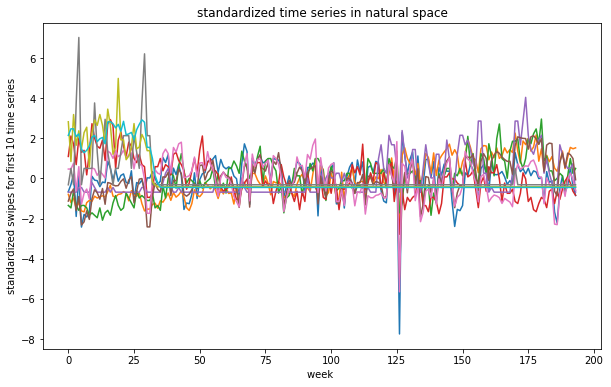

In [32]:
plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(standardized.iloc[i,:])
plt.title("standardized time series in natural space")
plt.xlabel("week ")
plt.ylabel("standardized swipes for first 10 time series")

Caption: The first 10 standardized weekly time series about swipes per ride type per station. The significant decrease is around 125 weeks.

In [33]:
#make x and y for the model
x = np.zeros((int(len(standardized.index)),int(len(standardized.columns)-1),2)) #(9174time seires,2,193observations)
x[:,:,0] = 1
y = np.zeros((int(len(standardized.index)),int(len(standardized.columns)-1)))
for i in range(len(standardized.index)):
    x[i,:,1] = (standardized.iloc[i,1:])
    y[i] = (standardized.iloc[i,:-1])

In [34]:
#fit 9714 ts model 
allfits = []
for i in range(len(standardized.index)):
    mod = sm.OLS(y[i],x[i]).fit()
    allfits.append(mod)
[a.params[0] for a in allfits[:10]]


[0.004042686907546406,
 -0.01107135756893437,
 -0.007787744130864504,
 0.008396593459559076,
 0.0008779571841231008,
 -0.0029400155878367158,
 0.004070994006168505,
 0.0006769025941288222,
 0.014864208750671744,
 0.013359347406187657]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [35]:
standardized['tsmean'] = standardized.mean(axis=1)
standardized['tsstd'] = standardized.std(axis=1)
standardized.head()

0         1         2         3         4         5         6  \
0 -0.656406 -0.306381  0.204605 -1.892991  0.166281 -2.421861 -1.790794   
1 -0.793281 -1.206117 -0.976764 -1.504277 -1.183182 -1.618954 -1.664825   
2 -1.344229 -1.467122 -0.606867 -1.344229 -1.590016 -1.344229 -1.344229   
3  1.095053  2.114439  1.706685  0.687298  2.012501  1.298930  1.400869   
4 -0.683990 -0.683990 -0.683990 -0.683990 -0.447880 -0.447880 -0.683990   

          7         8         9  ...         186       187       188  \
0 -1.918540 -1.688597  0.107518  ...   -2.222577 -0.541434  0.127957   
1 -1.206117 -1.091440 -1.137311  ...    0.353489  0.812196  1.362645   
2 -1.467122 -1.835803 -1.712909  ...    0.007602  0.253389  0.130495   
3  0.177605  1.298930  2.726072  ...   -0.637905 -1.045660 -0.535966   
4 -0.683990 -0.683990 -0.211769  ...   -0.447880  1.677114  1.204893   

        189       190       191       192       193        tsmean  tsstd  
0 -0.704949 -0.334485  0.503532 -0.365144 -0.848025  4.463783e-17    1.0  
1  0.491101  1.064485  1.546129  1.477322  1.523193  1.442145e-16    1.0  
2 -0.606867  0.130495  0.990751  0.253389  0.499176  2.051623e-15    1.0  
3 -0.128212  0.075666 -0.230150 -0.637905 -0.841782 -5.093291e-17    1.0  
4  0.732672  0.496562  0.496562  0.732672 -0.683990 -7.983305e-16    1.0  

[5 rows x 196 columns]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(\
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], \
              np.array(cleandf.normed_time_series_mean),np.array(cleandf.normed_time_series_std)]).T, \
     cleandf['type label'],test_size=0.33, random_state=42, shuffle=True)

In [37]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6146, 4), (3028, 4), (6146,), (3028,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [38]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [39]:
####since I don't have infinite number, I may not use it.
#X_train[~np.isfinite(X_train)] = 
#### ... make a choice about what to do with this datapoint. drop it or replace it with something

In [40]:
RandomForestClassifier?

Object `RandomForestClassifier` not found.


In [41]:
clf = rfc()...

SyntaxError: invalid syntax (<ipython-input-41-1a5347d0a0e0>, line 1)

and use sklearn confusion_matrix to see the errors

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [ ]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

In [ ]:
imshow(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred, target_names=ridetype))